# 자연어처리: 단어변환(Word2Vec)

-  딥러닝 모델에 텍스트를 input으로 넣는것은 불가, 그러나 숫자는 넣을 수 있음
    - 텍스트를 숫자로 변환하는 것이 필요(encoding, one-hot encoding, cosine similarity)
    - one-hot encoding의 문제점: 단어간의 연관성 표현 못함
    - cosine similarity의 문제점: 두개의 포인트 간의 각도가 모두 90도가 되기 때문에 모두 0이됨, 연관성 표현 못함
- Ecoding대신 Embedding 사용 필요
    - Encoding 보다 저차원 벡터로 표현 가능, similarity를 가질 수 있음   

# Word2Vec

- Word embedding
- Similarity는 neighbor word(비슷한 위치들간의 단어)로 부터 얻음
- Word2Vec data 생성을 위해 skipgram 사용(input: word, taget: neighbor)
- Unsupervised learning, self learning
- Deep learning 모델에 적용되는 data는 word embedding data를 encoding 한것
  - Word2Vec은 hidden layer가 됨
  - Input layer, Output layer는 one-hot encoding
  - output layer의 cost는 softmax, cross entropy, optimizer는 gradient 사용

### 1. Collect Data

In [1]:
corpus = ['king is a strong man', 
          'queen is a wise woman', 
          'boy is a young man',
          'girl is a young woman',
          'prince is a young king',
          'princess is a young queen',
          'man is strong', 
          'woman is pretty',
          'prince is a boy will be king',
          'princess is a girl will be queen']

### 2. Remove stop word

- 무의미한 단어 제거, 유사도 측정에 도움이 되지 않음

In [2]:
def remove_stop_words(corpus):
    stop_words = ['is', 'a', 'will', 'be']
    results = []
    
    for text in corpus:
        tmp = text.split(' ')
        
        for stop_word in stop_words:
            if stop_word in tmp:
                tmp.remove(stop_word)
        results.append(" ".join(tmp))
    return results

In [3]:
corpus = remove_stop_words(corpus)

In [4]:
corpus

['king strong man',
 'queen wise woman',
 'boy young man',
 'girl young woman',
 'prince young king',
 'princess young queen',
 'man strong',
 'woman pretty',
 'prince boy king',
 'princess girl queen']

In [5]:
words = []
for text in corpus:
    for word in text.split(' '):
        words.append(word)

words = set(words)

In [6]:
words

{'boy',
 'girl',
 'king',
 'man',
 'pretty',
 'prince',
 'princess',
 'queen',
 'strong',
 'wise',
 'woman',
 'young'}

### 3. Data Generation

- 왼쪽과 오른쪽에 있는 단어를 이웃 단어로 가짐

In [7]:
word2int = {}

for i, word in enumerate(words):
    word2int[word] = i

word2int

{'wise': 0,
 'woman': 1,
 'princess': 2,
 'king': 3,
 'strong': 4,
 'queen': 5,
 'prince': 6,
 'man': 7,
 'young': 8,
 'girl': 9,
 'boy': 10,
 'pretty': 11}

In [8]:
sentences = []

for sentence in corpus:
    sentences.append(sentence.split())

sentences

[['king', 'strong', 'man'],
 ['queen', 'wise', 'woman'],
 ['boy', 'young', 'man'],
 ['girl', 'young', 'woman'],
 ['prince', 'young', 'king'],
 ['princess', 'young', 'queen'],
 ['man', 'strong'],
 ['woman', 'pretty'],
 ['prince', 'boy', 'king'],
 ['princess', 'girl', 'queen']]

In [9]:
WINDOW_SIZE = 2

data = []

for sentence in sentences:
    for idx, word in enumerate(sentence):
        for neighbor in sentence[max(idx - WINDOW_SIZE, 0) : min(idx + WINDOW_SIZE, len(sentence)) + 1] : 
            if neighbor != word:
                data.append([word, neighbor])  
data

[['king', 'strong'],
 ['king', 'man'],
 ['strong', 'king'],
 ['strong', 'man'],
 ['man', 'king'],
 ['man', 'strong'],
 ['queen', 'wise'],
 ['queen', 'woman'],
 ['wise', 'queen'],
 ['wise', 'woman'],
 ['woman', 'queen'],
 ['woman', 'wise'],
 ['boy', 'young'],
 ['boy', 'man'],
 ['young', 'boy'],
 ['young', 'man'],
 ['man', 'boy'],
 ['man', 'young'],
 ['girl', 'young'],
 ['girl', 'woman'],
 ['young', 'girl'],
 ['young', 'woman'],
 ['woman', 'girl'],
 ['woman', 'young'],
 ['prince', 'young'],
 ['prince', 'king'],
 ['young', 'prince'],
 ['young', 'king'],
 ['king', 'prince'],
 ['king', 'young'],
 ['princess', 'young'],
 ['princess', 'queen'],
 ['young', 'princess'],
 ['young', 'queen'],
 ['queen', 'princess'],
 ['queen', 'young'],
 ['man', 'strong'],
 ['strong', 'man'],
 ['woman', 'pretty'],
 ['pretty', 'woman'],
 ['prince', 'boy'],
 ['prince', 'king'],
 ['boy', 'prince'],
 ['boy', 'king'],
 ['king', 'prince'],
 ['king', 'boy'],
 ['princess', 'girl'],
 ['princess', 'queen'],
 ['girl', 'prin

In [10]:
import pandas as pd

for text in corpus:
    print(text)

df = pd.DataFrame(data, columns=['input', 'label'])

king strong man
queen wise woman
boy young man
girl young woman
prince young king
princess young queen
man strong
woman pretty
prince boy king
princess girl queen


In [11]:
df.head(10)

,input,label
0,king,strong
1,king,man
2,strong,king
3,strong,man
4,man,king
5,man,strong
6,queen,wise
7,queen,woman
8,wise,queen
9,wise,woman


In [12]:
df.shape

(52, 2)

In [13]:
word2int

{'wise': 0,
 'woman': 1,
 'princess': 2,
 'king': 3,
 'strong': 4,
 'queen': 5,
 'prince': 6,
 'man': 7,
 'young': 8,
 'girl': 9,
 'boy': 10,
 'pretty': 11}

### 4. Define Tensorflow Graph

In [14]:
import tensorflow as tf
import numpy as np

ONE_HOT_DIM = len(words)

# function to convert numbers to one hot vectors
def to_one_hot_encoding(data_point_index):
    one_hot_encoding = np.zeros(ONE_HOT_DIM)
    one_hot_encoding[data_point_index] = 1
    return one_hot_encoding

X = [] # input word
Y = [] # target word

for x, y in zip(df['input'], df['label']):
    X.append(to_one_hot_encoding(word2int[ x ]))
    Y.append(to_one_hot_encoding(word2int[ y ]))

# convert them to numpy arrays
X_train = np.asarray(X)
Y_train = np.asarray(Y)

# making placeholders for X_train and Y_train
x = tf.placeholder(tf.float32, shape=(None, ONE_HOT_DIM))
y_label = tf.placeholder(tf.float32, shape=(None, ONE_HOT_DIM))

# word embedding will be 2 dimension for 2d visualization
EMBEDDING_DIM = 2 

# hidden layer: which represents word vector eventually
W1 = tf.Variable(tf.random_normal([ONE_HOT_DIM, EMBEDDING_DIM]))
b1 = tf.Variable(tf.random_normal([1])) #bias
hidden_layer = tf.add(tf.matmul(x,W1), b1)

# output layer
W2 = tf.Variable(tf.random_normal([EMBEDDING_DIM, ONE_HOT_DIM]))
b2 = tf.Variable(tf.random_normal([1]))
prediction = tf.nn.softmax(tf.add( tf.matmul(hidden_layer, W2), b2))

# loss function: cross entropy
loss = tf.reduce_mean(-tf.reduce_sum(y_label * tf.log(prediction), axis=[1]))

# training operation
train_op = tf.train.GradientDescentOptimizer(0.05).minimize(loss)

### 5. Train

In [20]:
with tf.Session() as sess:
    init = tf.global_variables_initializer()
    sess.run(init)
    
    iteration = 20000
    
    for i in range(iteration):
        loss_val, _ = sess.run([loss, train_op], feed_dict={x: X_train, y_label: Y_train})
        
        if i % 2000 == 0:
            print('iteration: '+str(i)+'\tloss: ', loss_val)
    
    vectors = sess.run(W1 + b1)
    print('\nvectors:\n', vectors)

iteration: 0	loss:  3.3613584
iteration: 2000	loss:  1.868216
iteration: 4000	loss:  1.8151354
iteration: 6000	loss:  1.7948487
iteration: 8000	loss:  1.7816541
iteration: 10000	loss:  1.77168
iteration: 12000	loss:  1.7641733
iteration: 14000	loss:  1.7582796
iteration: 16000	loss:  1.7534106
iteration: 18000	loss:  1.7492517

vectors:
 [[-1.2504249e+00 -6.1618328e+00]
 [ 4.2778850e-01 -4.7684026e-01]
 [ 2.4354458e-04 -2.2440426e+00]
 [-1.1283448e+00  1.7892706e-01]
 [-7.1307583e+00 -2.8885484e-01]
 [-9.2351437e-04 -8.5365212e-01]
 [-3.6851549e+00  3.1843793e-01]
 [-1.1738822e+00  4.5144796e-01]
 [-2.5490463e-01 -1.8785918e-01]
 [-9.4441110e-01 -2.7555633e+00]
 [-3.9600546e+00 -4.1348469e-01]
 [-2.3772700e+00 -5.3375196e+00]]


### 6. Word vector in table

In [23]:
w2v_df = pd.DataFrame(vectors, columns = ['x1', 'x2'])
w2v_df['word'] = words
w2v_df = w2v_df[['word', 'x1', 'x2']]
w2v_df

,word,x1,x2
0,wise,-1.250425,-6.161833
1,woman,0.427788,-0.476840
2,princess,0.000244,-2.244043
3,king,-1.128345,0.178927
4,strong,-7.130758,-0.288855
5,queen,-0.000924,-0.853652
6,prince,-3.685155,0.318438
7,man,-1.173882,0.451448
8,young,-0.254905,-0.187859
9,girl,-0.944411,-2.755563


### 7. Word vector in 2D chart

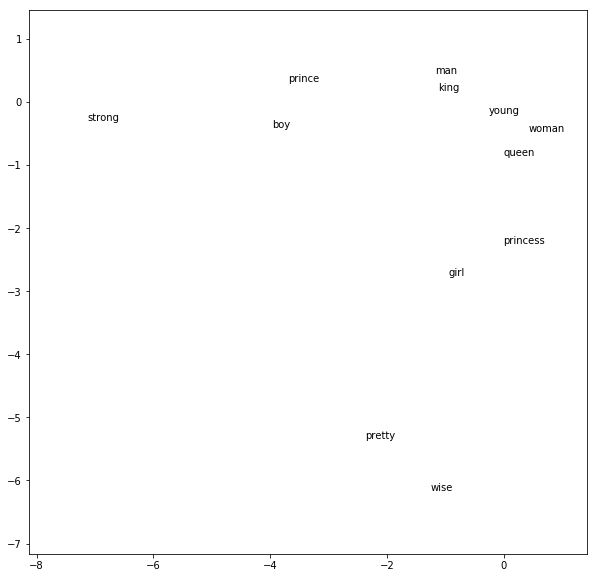

In [24]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

for word, x1, x2 in zip(w2v_df['word'], w2v_df['x1'], w2v_df['x2']):
    ax.annotate(word, (x1,x2))
    
PADDING = 1.0
x_axis_min = np.amin(vectors, axis=0)[0] - PADDING
y_axis_min = np.amin(vectors, axis=0)[1] - PADDING
x_axis_max = np.amax(vectors, axis=0)[0] + PADDING
y_axis_max = np.amax(vectors, axis=0)[1] + PADDING
 
plt.xlim(x_axis_min,x_axis_max)
plt.ylim(y_axis_min,y_axis_max)
plt.rcParams["figure.figsize"] = (10,10)

plt.show()

- 참고: https://github.com/minsuk-heo/python_tutorial/blob/master/data_science/nlp/word2vec_tensorflow.ipynb